## Data Analytics Assignment 2: Clustering - Sessa Empirical Estimator
### Submitted by Pintor & Wang

## Instructions:
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.



## Introduction
In this assignment, we aim to implement the Sessa Empirical Estimator in Python (converting from R program), using it on med_events_ATC dataset (AdhereR sample dataset). The original Sessa Empirical Estimator uses K-means clustering, but we also perform clustering using Dbscan as a comparison.

### 1. Import Libraries aqnd Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.stats import gaussian_kde
import random

# Set a different seed for reproducibility
np.random.seed(42)

# Load dataset
df = pd.read_csv("med_events_ATC.csv")
df.tail()

,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
1559,16,2058-07-12,60.0,50.0,R03AC12,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1560,16,2056-07-04,30.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1561,16,2057-11-02,60.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1562,16,2058-01-04,60.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1563,16,2058-04-20,120.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES


### 2. Renaming Columns & Covert eksd column to Datetime Format

In [18]:
# Rename columns
df = df.rename(columns={
    "PATIENT_ID": "pnr",
    "DATE": "eksd",
    "PERDAY": "perday",
    "CATEGORY": "ATC",
    "DURATION": "dur_original"
})

# Convert 'eksd' column to datetime format
df["eksd"] = pd.to_datetime(df["eksd"], format="%Y-%m-%d")

# Display the first few rows to verify changes
df.tail()

,pnr,eksd,dur_original,perday,ATC,CATEGORY_L1,CATEGORY_L2
1559,16,2058-07-12,60.0,50.0,R03AC12,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1560,16,2056-07-04,30.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1561,16,2057-11-02,60.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1562,16,2058-01-04,60.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES
1563,16,2058-04-20,120.0,500.0,R03AK06,RESPIRATORY SYSTEM,DRUGS FOR OBSTRUCTIVE AIRWAY DISEASES


- we rename the columns to match the R program
- converting the eksd column to datetime format, so we can perform operations like sorting, filtering by date, or time-based analysis more efficiently.

### 3. Filter for Medication J02AC02 (Example ATC), Sort Records by Patient and Prescription Date, Calculate Days Between Prescriptions (Per Patient)

In [3]:
# Filter for medication J02AC02
df_filtered = df[df["ATC"] == "J02AC02"]

# Sort records by patient and prescription date
df_filtered = df_filtered.sort_values(by=["pnr", "eksd"])

# Calculate days between prescriptions (per patient)
df_filtered["days_between"] = df_filtered.groupby("pnr")["eksd"].diff().dt.days

# Remove NaN values (first occurrence per patient)
df_filtered = df_filtered.dropna(subset=["days_between"])

# Assuming df_filtered is your DataFrame after filtering exclusions
df_sampled = df_filtered.groupby("pnr").sample(n=1, random_state=42)

- first, we filter for medication J02AC02
- then the dataset is sorted so that for each patient, the prescriptions appear in chronological order. This is important for analyzing prescription patterns over time.
- For each patient, the number of days between consecutive prescriptions is calculated. This gives insight into the prescription frequency for each individual.
- Any rows where the days between prescriptions is missing (such as the first prescription for each patient) are removed. This ensures that only valid and comparable data is used.
- From the remaining data, one prescription is randomly selected for each patient. This allows for analysis with a reduced dataset that still represents the original patient population.

### 4. Log-Transformed Event Interval Density Estimation

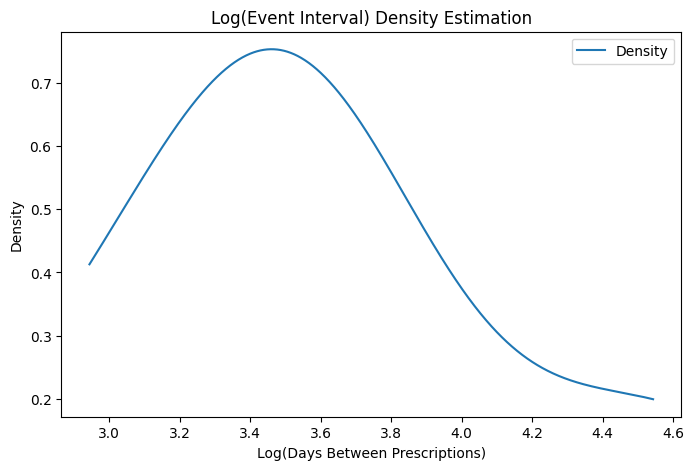

In [4]:
log_intervals = np.log(df_sampled["days_between"].values)
kde = gaussian_kde(log_intervals)

x_range = np.linspace(log_intervals.min(), log_intervals.max(), 1000)
y_values = kde(x_range)

plt.figure(figsize=(8, 5))
plt.plot(x_range, y_values, label="Density")
plt.title("Log(Event Interval) Density Estimation")
plt.xlabel("Log(Days Between Prescriptions)")
plt.ylabel("Density")
plt.legend()
plt.show()

- This  visualizes the distribution of the log-transformed days between prescriptions using Kernel Density Estimation (KDE). It applies a logarithmic transformation to the intervals and estimates the density of those values, then plots the resulting distribution.

### 5. ECDF Analysis for Event Intervals
- This function generates two Empirical Cumulative Distribution Function (ECDF) plots for a given medication. The first plot shows the full ECDF of event intervals, while the second one focuses on the data after trimming the top 20% of the longest refill gaps. This allows for a more accurate representation of the typical event intervals by removing outliers or extreme values.

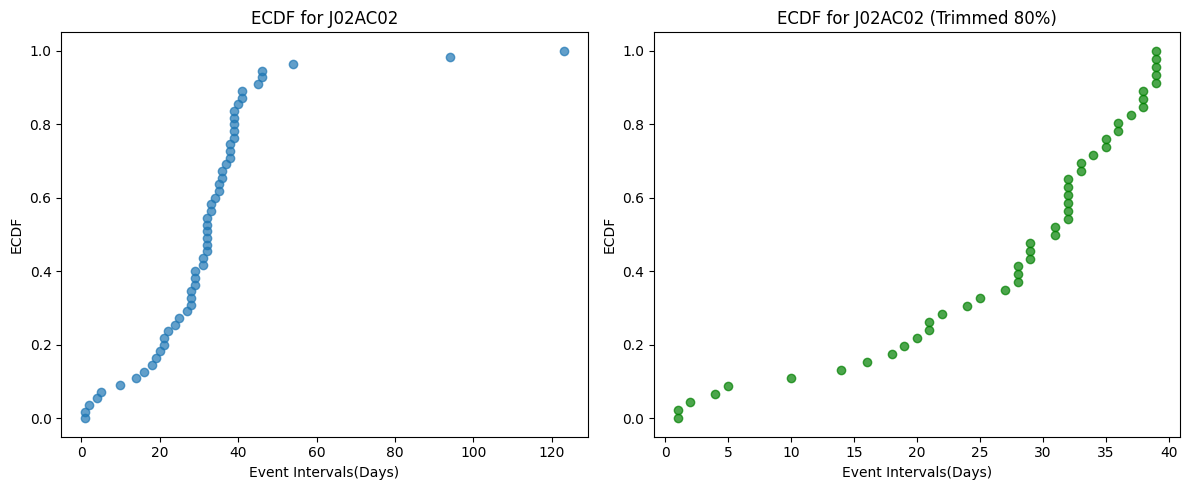

Filtered intervals for J02AC02 range from 1.0 to 39.0 days


In [5]:
def analyze_ecdf(intervals, medication_name):
    sorted_intervals = np.sort(intervals)
    n = len(sorted_intervals)
    cumulative_distribution = np.linspace(0, 1, n)

    # Set up figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Full ECDF
    axes[0].scatter(sorted_intervals, cumulative_distribution, alpha=0.7, marker="o")
    axes[0].set_title(f"ECDF for {medication_name}")
    axes[0].set_xlabel("Event Intervals(Days)")
    axes[0].set_ylabel("ECDF")

    # Remove top 20% (longest refill gaps)
    cutoff = np.percentile(sorted_intervals, 80)
    filtered_intervals = sorted_intervals[sorted_intervals <= cutoff]

    # Compute new ECDF for filtered data
    n_filtered = len(filtered_intervals)
    cumulative_filtered = np.linspace(0, 1, n_filtered)

    # Plot filtered ECDF
    axes[1].scatter(filtered_intervals, cumulative_filtered, alpha=0.7, marker="o", color='green')
    axes[1].set_title(f"ECDF for {medication_name} (Trimmed 80%)")
    axes[1].set_xlabel("Event Intervals(Days)")
    axes[1].set_ylabel("ECDF")

    plt.tight_layout()
    plt.show()

    return filtered_intervals

# Extract intervals for J02AC02
interval_data = df_filtered["days_between"].values

# Apply function to visualize and filter ECDF for J02AC02
filtered_intervals = analyze_ecdf(interval_data, "J02AC02")

# Display the range of filtered intervals
print(f"Filtered intervals for J02AC02 range from {filtered_intervals.min()} to {filtered_intervals.max()} days")

### 6. K-Means Clustering with Silhouette Score Evaluation
- Now we find the optimal number of clusters (k) for K-Means clustering by evaluating silhouette scores across a range of k-values (from 2 to 9 by default). The silhouette score helps assess how well-defined the clusters are, with higher scores indicating better-defined clusters.

In [6]:
def find_best_kmeans(data, k_range=range(2, 10)):
    best_k = None
    best_score = -1
    silhouette_scores = {}

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        silhouette_scores[k] = score
        print(f"Silhouette score for {k} clusters: {score:.4f}")

        if score > best_score:
            best_score = score
            best_k = k

    print(f"\nBest number of clusters: {best_k}")
    return best_k

# Ensure no negative or zero values before log transformation
df_filtered["days_between"] = df_filtered["days_between"].clip(lower=1)

# Log-transform the days between prescriptions
log_gap_values = np.log(df_filtered["days_between"].values).reshape(-1, 1)

# Find the best k
best_k = find_best_kmeans(log_gap_values)

Silhouette score for 2 clusters: 0.8201
Silhouette score for 3 clusters: 0.7078
Silhouette score for 4 clusters: 0.6415
Silhouette score for 5 clusters: 0.5577
Silhouette score for 6 clusters: 0.5681
Silhouette score for 7 clusters: 0.5704
Silhouette score for 8 clusters: 0.5832
Silhouette score for 9 clusters: 0.5654

Best number of clusters: 2


### 7. Silhouette Analysis Plot
- This function generates a silhouette analysis plot for the chosen number of clusters (best_k), allowing us to visually assess the quality of the clusters formed by the K-Means algorithm.

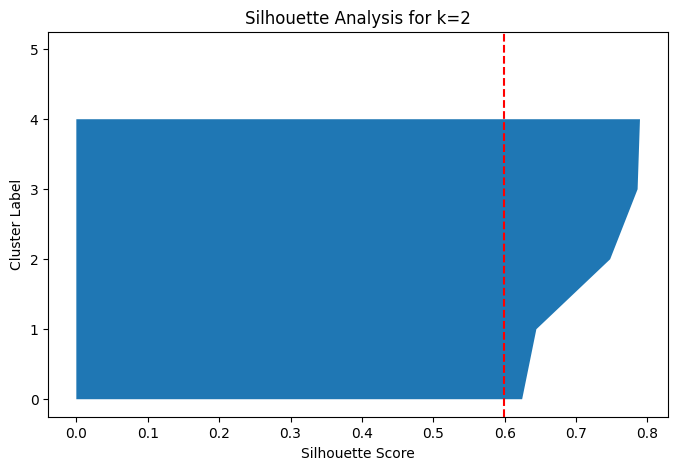

In [7]:
def plot_silhouette_analysis(data, best_k):
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=best_k, random_state=42)
    cluster_labels = kmeans.fit_predict(data.reshape(-1, 1))

    silhouette_vals = silhouette_samples(data.reshape(-1, 1), cluster_labels)
    y_lower, y_upper = 0, 0

    plt.figure(figsize=(8, 5))
    for i in range(best_k):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals)
        y_lower = y_upper

    plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
    plt.title(f"Silhouette Analysis for k={best_k}")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Cluster Label")
    plt.show()

plot_silhouette_analysis(log_intervals, best_k)

### 8. K-Distance Plot for DBSCAN's Epsilon (eps)
- This function generates a k-distance plot to help identify the optimal value for epsilon (eps) in the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clustering algorithm.

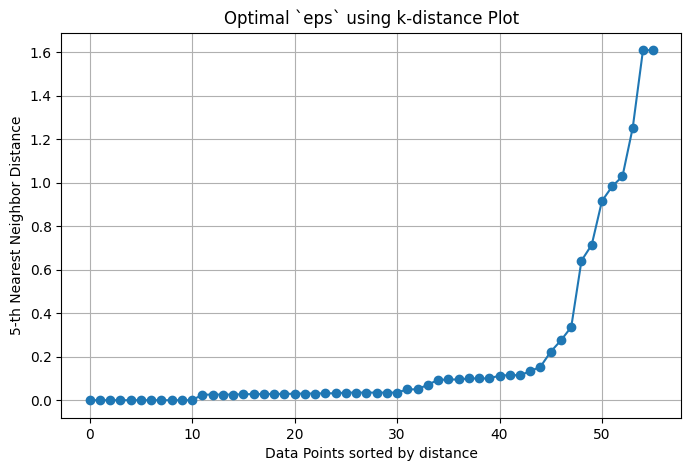

In [8]:
def find_optimal_eps(data, k=5):
    """
    Finds the optimal epsilon for DBSCAN using a k-distance plot.
    
    Args:
        data (np.ndarray): Input data (e.g., log-transformed time gaps).
        k (int): Number of neighbors to consider.
    
    Returns:
        None (Displays the plot)
    """
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    
    # Sort the distances to find the "elbow point"
    sorted_distances = np.sort(distances[:, -1])  # Take the k-th distance
    
    # Plot the k-distance graph
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_distances, marker="o")
    plt.xlabel("Data Points sorted by distance")
    plt.ylabel(f"{k}-th Nearest Neighbor Distance")
    plt.title("Optimal `eps` using k-distance Plot")
    plt.grid()
    plt.show()

# Apply function to log-transformed time gaps
find_optimal_eps(log_gap_values)

In [9]:
for eps_val in [0.05, 0.1, 0.2, 0.25]:
    dbscan = DBSCAN(eps=eps_val, min_samples=5)
    labels = dbscan.fit_predict(log_gap_values)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"eps={eps_val}: Found {num_clusters} clusters (excluding noise)")

eps=0.05: Found 2 clusters (excluding noise)
eps=0.1: Found 2 clusters (excluding noise)
eps=0.2: Found 1 clusters (excluding noise)
eps=0.25: Found 1 clusters (excluding noise)


### 9. K-Means Clustering of Log-Transformed Intervals
- Applying the K-Means clustering algorithm to group data into clusters based on the log-transformed refill gap intervals. The result is visualized, with each data point assigned to a cluster, and the centroids of the clusters marked on the plot.

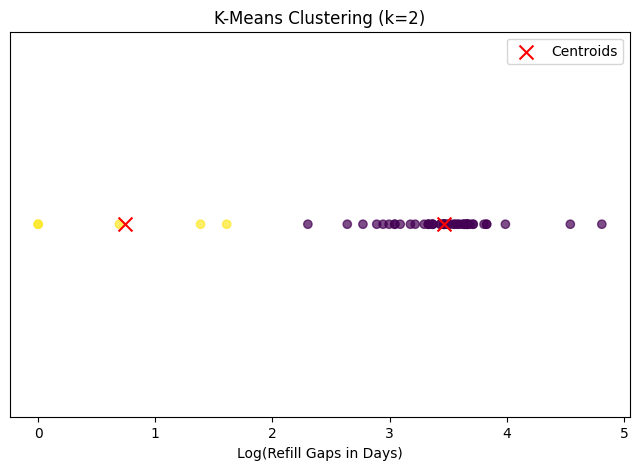

In [10]:
def kmeans_clustering(data, k):
    """
    Applies K-Means clustering and visualizes the clusters.
    
    Args:
        data (np.ndarray): Log-transformed intervals.
        k (int): Optimal number of clusters.
    
    Returns:
        cluster_labels (np.ndarray): Labels assigned to each point.
        centroids (np.ndarray): Cluster centroids.
    """
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_

    # Scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(data, np.zeros_like(data), c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.scatter(centroids, np.zeros_like(centroids), color='red', marker='x', s=100, label="Centroids")
    plt.title(f"K-Means Clustering (k={k})")
    plt.xlabel("Log(Refill Gaps in Days)")
    plt.yticks([])  # Remove y-axis for clarity
    plt.legend()
    plt.show()

    return cluster_labels, centroids

# Apply K-Means
kmeans_labels, kmeans_centroids = kmeans_clustering(log_gap_values, best_k)

### 10. DBSCAN Clustering of Log-Transformed Intervals
- applying the DBSCAN algorithm to group data into clusters based on density. It also highlights any noise points (outliers) that do not fit well into any cluster.

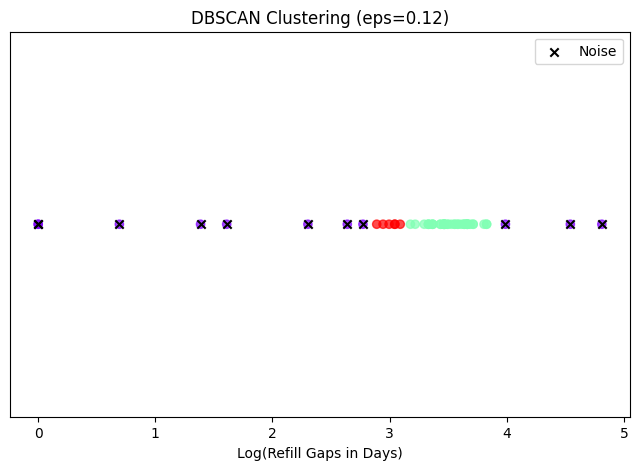

DBSCAN (eps=0.12): 2 clusters found, 11 noise points


In [11]:
def dbscan_clustering(data, eps, min_samples=5):
    """
    Applies DBSCAN clustering and visualizes results.
    
    Args:
        data (np.ndarray): Log-transformed intervals.
        eps (float): DBSCAN epsilon value.
        min_samples (int): Minimum points to form a cluster.
    
    Returns:
        cluster_labels (np.ndarray): Labels assigned (-1 for noise).
        num_clusters (int): Number of clusters found.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(data)

    # Number of clusters (excluding noise)
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    num_noise = np.sum(cluster_labels == -1)

    # Scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(data, np.zeros_like(data), c=cluster_labels, cmap='rainbow', alpha=0.7)
    plt.title(f"DBSCAN Clustering (eps={eps})")
    plt.xlabel("Log(Refill Gaps in Days)")
    plt.yticks([])
    
    # Highlight noise points
    if num_noise > 0:
        plt.scatter(data[cluster_labels == -1], np.zeros_like(data[cluster_labels == -1]), color="black", label="Noise", marker="x")

    plt.legend()
    plt.show()

    print(f"DBSCAN (eps={eps}): {num_clusters} clusters found, {num_noise} noise points")
    
    return cluster_labels, num_clusters

# Apply DBSCAN
dbscan_labels, num_clusters = dbscan_clustering(log_gap_values, eps=0.12)

### 11. Cluster Summary Generation
- We generate a summary for each cluster, including the size and statistical properties (such as minimum, maximum, mean, median, and standard deviation) of the data points in that cluster. It also distinguishes noise points for DBSCAN.

In [12]:
def summarize_clusters(data, labels, method_name):
    """
    Generates a summary of clustering results.
    
    Args:
        data (np.ndarray): Log-transformed intervals.
        labels (np.ndarray): Cluster labels assigned by the algorithm.
        method_name (str): Name of the clustering method (K-Means or DBSCAN).
    
    Returns:
        summary_df (pd.DataFrame): DataFrame summarizing cluster statistics.
    """
    unique_labels = np.unique(labels)
    summary_list = []
    
    for label in unique_labels:
        if label == -1:
            cluster_name = "Noise"
        else:
            cluster_name = f"Cluster {label}"
        
        cluster_data = data[labels == label]
        summary_list.append({
            "Cluster": cluster_name,
            "Size": len(cluster_data),
            "Min": np.min(cluster_data) if len(cluster_data) > 0 else None,
            "Max": np.max(cluster_data) if len(cluster_data) > 0 else None,
            "Mean": np.mean(cluster_data) if len(cluster_data) > 0 else None,
            "Median": np.median(cluster_data) if len(cluster_data) > 0 else None,
            "Std Dev": np.std(cluster_data) if len(cluster_data) > 0 else None
        })
    
    summary_df = pd.DataFrame(summary_list)
    print(f"\nSummary for {method_name} Clustering:")
    print(summary_df)
    return summary_df

# Generate summaries for K-Means and DBSCAN
kmeans_summary = summarize_clusters(log_gap_values.flatten(), kmeans_labels, "K-Means")
dbscan_summary = summarize_clusters(log_gap_values.flatten(), dbscan_labels, "DBSCAN")



Summary for K-Means Clustering:
     Cluster  Size       Min       Max      Mean    Median   Std Dev
0  Cluster 0    51  2.302585  4.812184  3.465520  3.465736  0.402144
1  Cluster 1     5  0.000000  1.609438  0.737776  0.693147  0.673942

Summary for DBSCAN Clustering:
     Cluster  Size       Min       Max      Mean    Median   Std Dev
0      Noise    11  0.000000  4.812184  2.249779  2.302585  1.623139
1  Cluster 0    39  3.178054  3.828641  3.530057  3.526361  0.160351
2  Cluster 1     6  2.890372  3.091042  3.001772  3.020127  0.067525


**Insights from the Clustering Results**
- K-Means Clustering Summary:
Cluster 0 (Size = 51):

Range: The values in this cluster range from approximately 2.30 to 4.81 (log-transformed refill gaps).
Mean: The mean value is 3.47, with a median very close to the mean (3.47), indicating a fairly symmetric distribution of refill gaps in this cluster.
Std Dev: The standard deviation is 0.40, which is relatively low, suggesting that the data points in this cluster are fairly close to the mean, with not much variation.
Cluster 1 (Size = 5):

Range: The values range from 0.00 to 1.61.
Mean: The mean is 0.74, and the median is slightly lower at 0.69, indicating a relatively skewed distribution where most points are closer to the lower end of the range.
Std Dev: The standard deviation is high at 0.67, meaning there’s significant variation among the small number of data points in this cluster.

**Insight: Cluster 0 is larger and has more consistent refill gaps, while Cluster 1 is smaller and contains more varied data. Cluster 1 might represent an outlier or a specific subset of refill gaps, possibly linked to rare behaviors or exceptions in the data.**

- **DBSCAN Clustering Summary:**
Noise (Size = 11):

These are points that DBSCAN could not assign to any cluster, likely due to having values that are too sparse or distant from the other data points.
Range: The noise points have a range from 0.00 to 4.81 and a mean of 2.25, with a high standard deviation of 1.62, indicating significant variability.
Insight: These points might represent outliers or data points with unusual refill patterns that don't fit into the more well-defined clusters.

Cluster 0 (Size = 39):

Range: The values in this cluster range from 3.18 to 3.83.
Mean: The mean is 3.53, with a median of 3.53, showing that this cluster has a fairly consistent distribution.
Std Dev: The standard deviation is low at 0.16, indicating that the refill gaps are tightly grouped around the mean.
Cluster 1 (Size = 6):

Range: The values in this cluster range from 2.89 to 3.09.
Mean: The mean is 3.00, with a median of 3.02, which is almost identical, suggesting symmetry and consistency in this cluster as well.
Std Dev: The standard deviation is low (0.07), indicating very little variation within this cluster.

**Insight: Cluster 0 seems to represent the main group of refill gaps with a well-defined range and low variability, while Cluster 1 is a smaller, more tightly grouped cluster that shares a similar range but is distinct from Cluster 0.
The Noise points are likely anomalies or points that don’t fit the general refill gap patterns.**


#### Key Takeaways:
- K-Means identifies two clusters, one of which is much larger and more consistent, while the other is smaller and more variable. The smaller cluster (Cluster 1) might require further exploration to understand its significance.
- DBSCAN identifies a larger, well-defined cluster (Cluster 0), a smaller cluster (Cluster 1), and a set of Noise points. The Noise points indicate anomalies or edge cases in refill behavior.
- Both clustering methods reveal that most of the data points are tightly grouped, but there are some outliers that don’t fit well into the general pattern.

### 12. Get Computed Durations and Assign to Patients
- This code adds K-Means cluster labels and computed median days_between for each cluster to the df_filtered DataFrame. It groups patients by their pnr, assigns the cluster label and median duration, and then merges this information into the original DataFrame for further analysis of patient clustering.

In [13]:
# Create a copy of df_filtered
df_filtered_copy = df_filtered.copy()

# Add cluster labels to df_filtered based on the KMeans labels
df_filtered['cluster_label'] = kmeans_labels

# Step 1: Compute median days_between for each cluster
cluster_medians = df_filtered.groupby('cluster_label')['days_between'].median().reset_index()
cluster_medians = cluster_medians.rename(columns={'days_between': 'computed_median_duration'})

# Step 2: Merge computed medians back to the original df_filtered
df_filtered = pd.merge(df_filtered, cluster_medians, on='cluster_label', how='left')

# Step 3: Assign the cluster label to each patient
def assign_cluster_and_median(patient_group):
    # Keep the assigned cluster label and the computed median duration for each patient
    patient_group['assigned_cluster_label'] = patient_group['cluster_label'].iloc[0]  # Taking the first label in the group
    patient_group['assigned_computed_median_duration'] = patient_group['computed_median_duration'].iloc[0]  # Taking the first median duration in the group
    return patient_group

# Apply this function to each patient's data (grouped by 'pnr')
df_filtered = df_filtered.groupby('pnr').apply(assign_cluster_and_median)

# Display the updated dataframe with the assigned cluster label and computed median duration
df_filtered[['pnr', 'eksd', 'days_between', 'cluster_label', 'computed_median_duration', 'assigned_cluster_label', 'assigned_computed_median_duration']].tail()


pnr       eksd  days_between  cluster_label  computed_median_duration  \
pnr                                                                             
16  51   16 2057-12-05           2.0              1                       2.0   
    52   16 2058-01-12          38.0              0                      32.0   
    53   16 2058-02-10          29.0              0                      32.0   
    54   16 2058-03-01          19.0              0                      32.0   
    55   16 2058-04-01          31.0              0                      32.0   

        assigned_cluster_label  assigned_computed_median_duration  
pnr                                                                
16  51                       0                               32.0  
    52                       0                               32.0  
    53                       0                               32.0  
    54                       0                               32.0  
    55                       0                               32.0

## Conclusion


In conclusion, both K-Means and DBSCAN were applied to cluster patients based on their prescription intervals, but each method has distinct characteristics that influence their results. K-Means is sensitive to the number of clusters specified and performs well when clusters are spherical and evenly distributed. It generally works faster but can be impacted by outliers and may struggle with non-linear data distributions. On the other hand, DBSCAN does not require a predefined number of clusters and can handle clusters of arbitrary shapes, making it more robust to outliers and varying densities, but it may struggle with high-dimensional data or highly uneven distributions.

In this analysis, K-Means performed better in terms of clustering patients with more consistent gaps between prescriptions, as the silhouette scores suggested clear separation between clusters. DBSCAN, while able to identify noise, did not generate as well-defined clusters, and the number of clusters was more variable. The choice between the two methods depends on the data's nature and the desired outcome: K-Means is preferable for well-separated, relatively even clusters, while DBSCAN is better for identifying clusters of varying shapes and dealing with outliers.